In [3]:
import pandas as pd, seaborn as sns, torch, warnings
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn as nn, optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset

warnings.filterwarnings('ignore')

In [4]:
sns.set(style = 'whitegrid')
plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large', titleweight = 'bold', titlesize = 18, titlepad = 10)
plt.rc('animation', html = 'html5')

In [5]:
def classify_health_impact(score):
    if score >= 80:
        return 0  
    elif score >= 60:
        return 1  
    elif score >= 40:
        return 2  
    elif score >= 20:
        return 3  
    else:
        return 4  

In [6]:
air = pd.read_csv('air_quality_health_impact_data.csv')
air_cleaned = air.drop(columns = ['RecordID'])
for col in ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3']:
    Q1 = air_cleaned[col].quantile(0.25)
    Q3 = air_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    air_cleaned[col] = air_cleaned[col].apply(lambda x: min(max(x, lower_bound), upper_bound))
air_cleaned['HealthImpactClass'] = air_cleaned['HealthImpactScore'].apply(classify_health_impact)

In [7]:
y = air_cleaned['HealthImpactClass']
x = air_cleaned.drop(['HealthImpactClass', 'HealthImpactScore'], axis = 1)
scaler = StandardScaler()
x = scaler.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 52)

In [8]:
xtensor = torch.tensor(x, dtype = torch.float32)
ytensor = torch.tensor(y, dtype = torch.long)
dataset = TensorDataset(xtensor, ytensor)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32)

In [10]:
class HealthImpactClassifier1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(HealthImpactClassifier1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

In [11]:
model1 = HealthImpactClassifier1(x.shape[1], 64, 5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr = 0.001)

In [12]:
for epoch in range(20):
    model1.train()
    running_loss = 0.0
    for xbatch, ybatch in train_loader:
        outputs = model1(xbatch)
        loss = criterion(outputs, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/20], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/20], Loss: 0.6151
Epoch [2/20], Loss: 0.2836
Epoch [3/20], Loss: 0.2109
Epoch [4/20], Loss: 0.1721
Epoch [5/20], Loss: 0.1478
Epoch [6/20], Loss: 0.1316
Epoch [7/20], Loss: 0.1191
Epoch [8/20], Loss: 0.1066
Epoch [9/20], Loss: 0.0989
Epoch [10/20], Loss: 0.0888
Epoch [11/20], Loss: 0.0807
Epoch [12/20], Loss: 0.0733
Epoch [13/20], Loss: 0.0673
Epoch [14/20], Loss: 0.0597
Epoch [15/20], Loss: 0.0560
Epoch [16/20], Loss: 0.0502
Epoch [17/20], Loss: 0.0445
Epoch [18/20], Loss: 0.0428
Epoch [19/20], Loss: 0.0385
Epoch [20/20], Loss: 0.0350


In [13]:
model1.eval()
ytrue = []
ypred = []
with torch.no_grad():
    for xbatch, ybatch in test_loader:
        outputs = model1(xbatch)
        _, predicted = torch.max(outputs, 1)
        ytrue.extend(ybatch.tolist())
        ypred.extend(predicted.tolist())
accuracy = accuracy_score(ytrue, ypred)
report = classification_report(ytrue, ypred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)

Accuracy: 97.08%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1508
           1       0.84      0.89      0.87       157
           2       0.87      0.79      0.83        68
           3       0.64      0.64      0.64        11

    accuracy                           0.97      1744
   macro avg       0.84      0.83      0.83      1744
weighted avg       0.97      0.97      0.97      1744



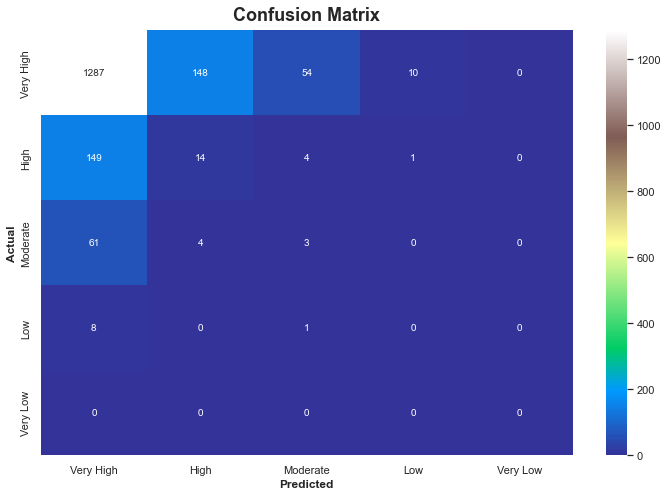

In [14]:
plt.figure(figsize = (10, 7))
class_labels = ['Very High', 'High', 'Moderate', 'Low', 'Very Low']
sns.heatmap(confusion_matrix(ytest, ypred, labels = [0, 1, 2, 3, 4]), annot = True, cmap = 'terrain', fmt = 'd', xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
model2 = nn.Sequential(
    nn.Linear(x.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 5)
)
optimizer = optim.Adam(model2.parameters(), lr = 0.001)

In [16]:
for epoch in range(20):
    model2.train()
    running_loss = 0.0
    for xbatch, ybatch in train_loader:
        outputs = model2(xbatch)
        loss = criterion(outputs, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/20], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/20], Loss: 0.6132
Epoch [2/20], Loss: 0.2636
Epoch [3/20], Loss: 0.1969
Epoch [4/20], Loss: 0.1622
Epoch [5/20], Loss: 0.1377
Epoch [6/20], Loss: 0.1249
Epoch [7/20], Loss: 0.1074
Epoch [8/20], Loss: 0.0948
Epoch [9/20], Loss: 0.0836
Epoch [10/20], Loss: 0.0759
Epoch [11/20], Loss: 0.0734
Epoch [12/20], Loss: 0.0686
Epoch [13/20], Loss: 0.0589
Epoch [14/20], Loss: 0.0518
Epoch [15/20], Loss: 0.0481
Epoch [16/20], Loss: 0.0440
Epoch [17/20], Loss: 0.0399
Epoch [18/20], Loss: 0.0368
Epoch [19/20], Loss: 0.0339
Epoch [20/20], Loss: 0.0302


In [17]:
model2.eval()
ytrue = []
ypred = []
with torch.no_grad():
    for xbatch, ybatch in test_loader:
        outputs = model2(xbatch)
        _, predicted = torch.max(outputs, 1)
        ytrue.extend(ybatch.tolist())
        ypred.extend(predicted.tolist())
accuracy = accuracy_score(ytrue, ypred)
report = classification_report(ytrue, ypred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)

Accuracy: 97.76%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1508
           1       0.87      0.94      0.90       157
           2       0.83      0.87      0.85        68
           3       1.00      0.36      0.53        11

    accuracy                           0.98      1744
   macro avg       0.92      0.79      0.82      1744
weighted avg       0.98      0.98      0.98      1744



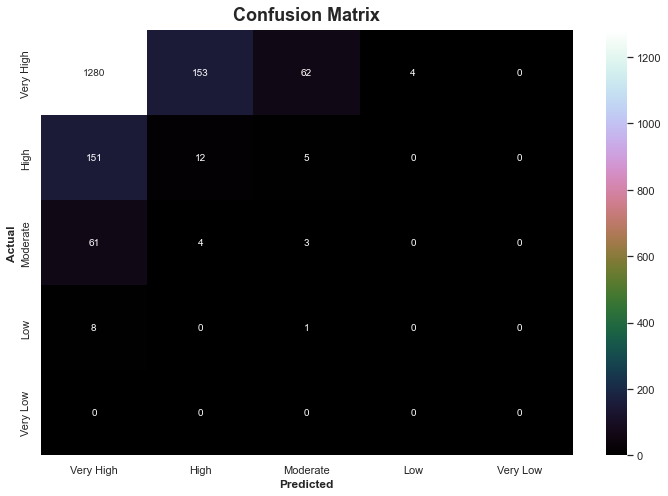

In [18]:
plt.figure(figsize = (10, 7))
class_labels = ['Very High', 'High', 'Moderate', 'Low', 'Very Low']
sns.heatmap(confusion_matrix(ytest, ypred, labels = [0, 1, 2, 3, 4]), annot = True, cmap = 'cubehelix', fmt = 'd', xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()